
# Running SCICoNE on DLP+ data

In this notebook we apply SCICoNE to DLP+ data from 3 cell lines grown from primary tumour, metastasis and ascites obtained from an Ovarian Cancer patient.  The data is available [here](https://doi.org/10.5281/zenodo.3445364) and was [published in Cell](https://doi.org/10.1016/j.cell.2019.10.026).  

Note: we recommend you to go through the [SCICoNE tutorial](https://github.com/cbg-ethz/SCICoNE/blob/master/notebooks/tutorial.ipynb) before running this notebook.
    

In [1]:

import scicone
import numpy as np
import pandas as pd

install_path = '../build/'
temporary_outpath = './dlp_temp/'
seed = 42 # for reproducibility

np.random.seed(seed)

# Create SCICoNE object
sci = scicone.SCICoNE(install_path, temporary_outpath, verbose=False)


Using binaries at ../build/



First download the data using:

```
wget https://zenodo.org/record/3445364/files/ov2295_cell_metrics.csv.gz
wget https://zenodo.org/record/3445364/files/ov2295_cell_cn.csv.gz
```


In [2]:

ov_metrics = pd.read_csv('./ov2295_cell_metrics.csv.gz')
ov_metrics = ov_metrics.query('quality > 0.85')

ov_data = pd.read_csv('./ov2295_cell_cn.csv.gz')
ov_data = ov_data.drop(['sample_id', 'library_id'], axis=1)
ov_data = ov_data.merge(ov_metrics[['cell_id']])


In [3]:

# Random subset of 100 cells
ov_metrics = ov_metrics.sample(100)
ov_data = ov_data.merge(ov_metrics[['cell_id']])


In [4]:

ov_data.head()


,cell_id,chr,start,end,reads,copy,state
0,SA922-A90554B-R29-C35,1,1,500000,42,NaN,3
1,SA922-A90554B-R29-C35,1,500001,1000000,988,NaN,3
2,SA922-A90554B-R29-C35,1,1000001,1500000,1682,2.372057,3
3,SA922-A90554B-R29-C35,1,1500001,2000000,1530,2.162089,3
4,SA922-A90554B-R29-C35,1,2000001,2500000,1860,2.619696,3


In [5]:

# Create a normalized read count column

ov_data = ov_data.merge(ov_data.groupby(['cell_id'])['reads'].sum().rename('total_reads').reset_index())
ov_data = ov_data.merge(ov_data.groupby(['cell_id'])['copy'].sum().rename('total_copy').reset_index())

ov_data['adjusted_reads'] = ov_data['copy'] * ov_data['total_reads'] / ov_data['total_copy'] 


In [6]:

matrix = (
    ov_data
    .set_index(['chr', 'start', 'end', 'cell_id'])
    .unstack()['adjusted_reads'].fillna(0).T.values)

matrix.shape


(100, 6206)

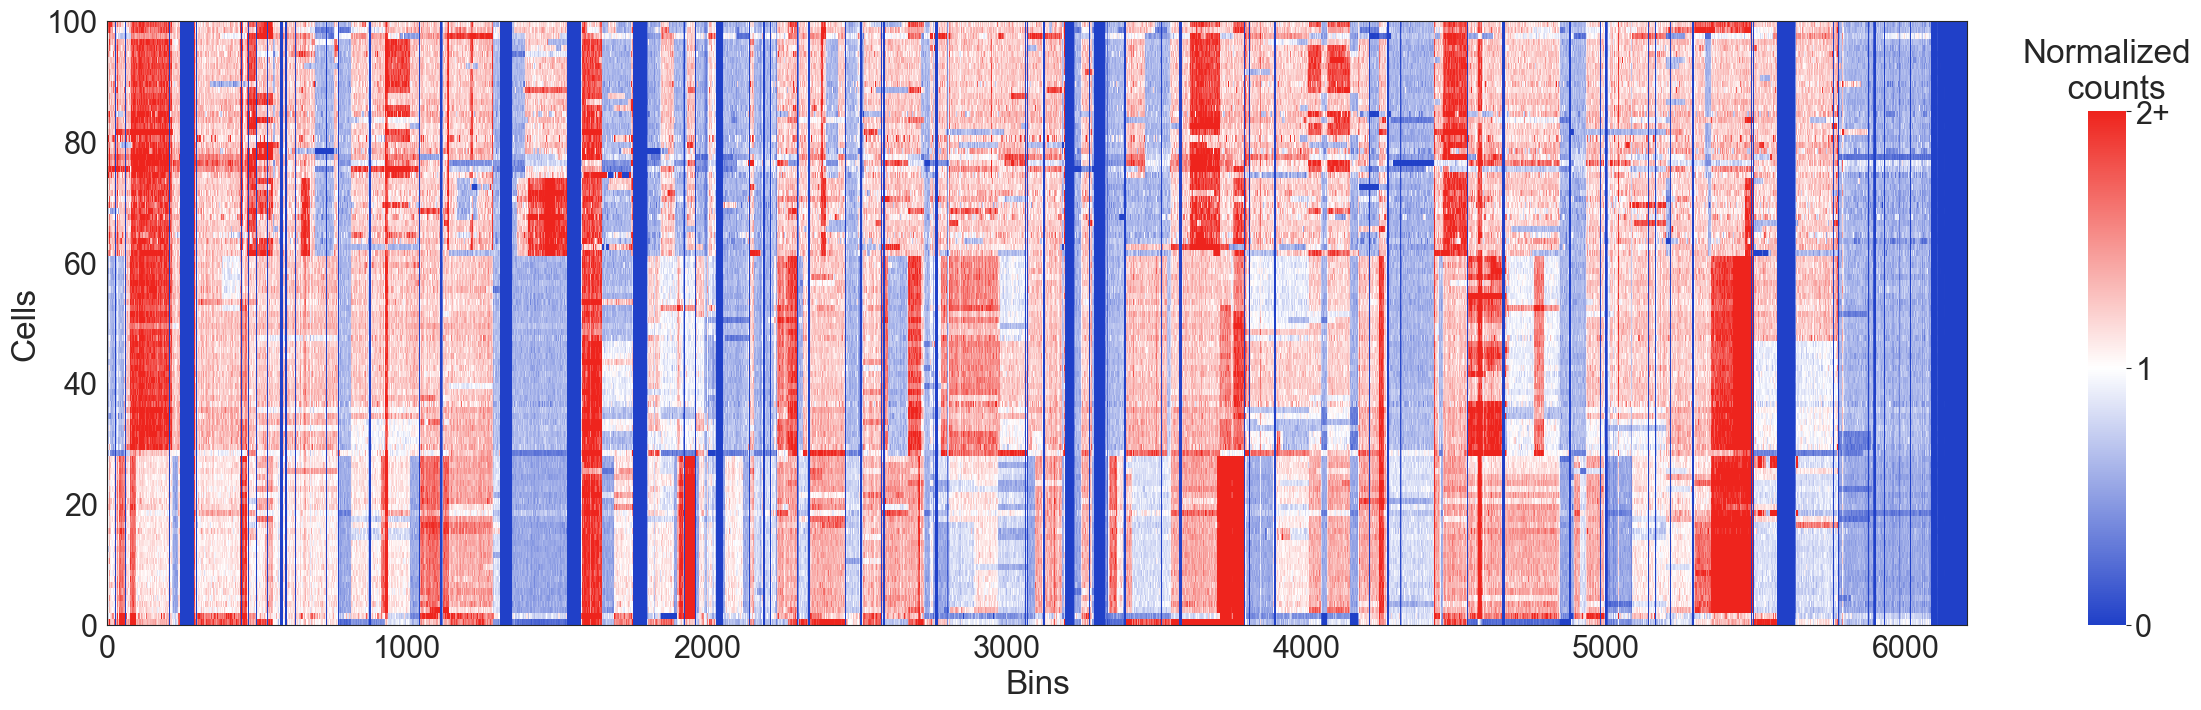

In [7]:

normalized_counts = matrix / np.sum(np.abs(matrix), axis=1).reshape(-1, 1)
normalized_counts *= normalized_counts.shape[1]

scicone.plotting.plot_matrix(
    normalized_counts, cbar_title='Normalized\n  counts', vmax=2,
    cluster=True)


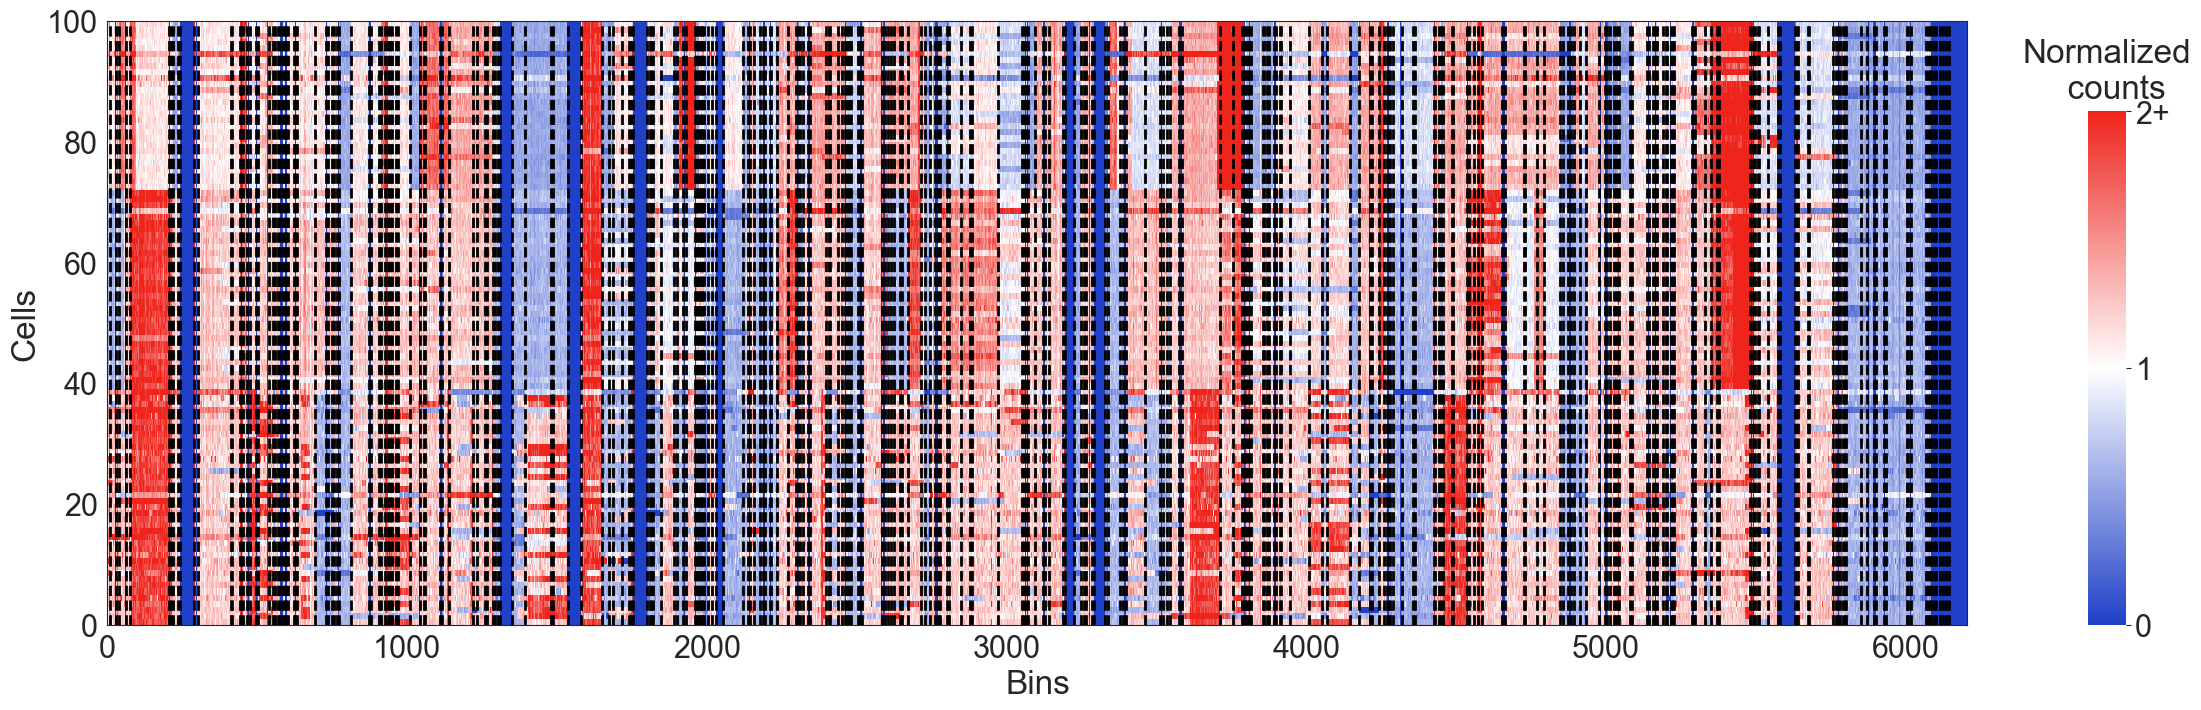

In [8]:

bps = sci.detect_breakpoints(data=matrix, verbosity=1, window_size=5)

scicone.plotting.plot_matrix(normalized_counts, bps=bps['segmented_regions'],
                             cbar_title='Normalized\n  counts', vmax=2)


In [12]:

inferred_tree = sci.learn_tree(
    matrix, bps['segmented_region_sizes'],
    cluster_tree_n_iters=40000,
    cluster=True, full=False, n_reps=10, max_tries=4,
    copy_number_limit=4, seed=seed)


Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 10
Setting min_cluster_size to 1
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.0038101673126220703 seconds
Jaccard graph constructed in 0.00554203987121582 seconds
Wrote graph to binary file in 0.001461029052734375 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.77152
Louvain completed 21 runs in 0.19278407096862793 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 0.38921189308166504 seconds
Found 6 clusters.
Cluster sizes: [26. 21. 19. 13. 12.  9.]
Cluster tree finished with a robustness score of 1.0 after 1 tries


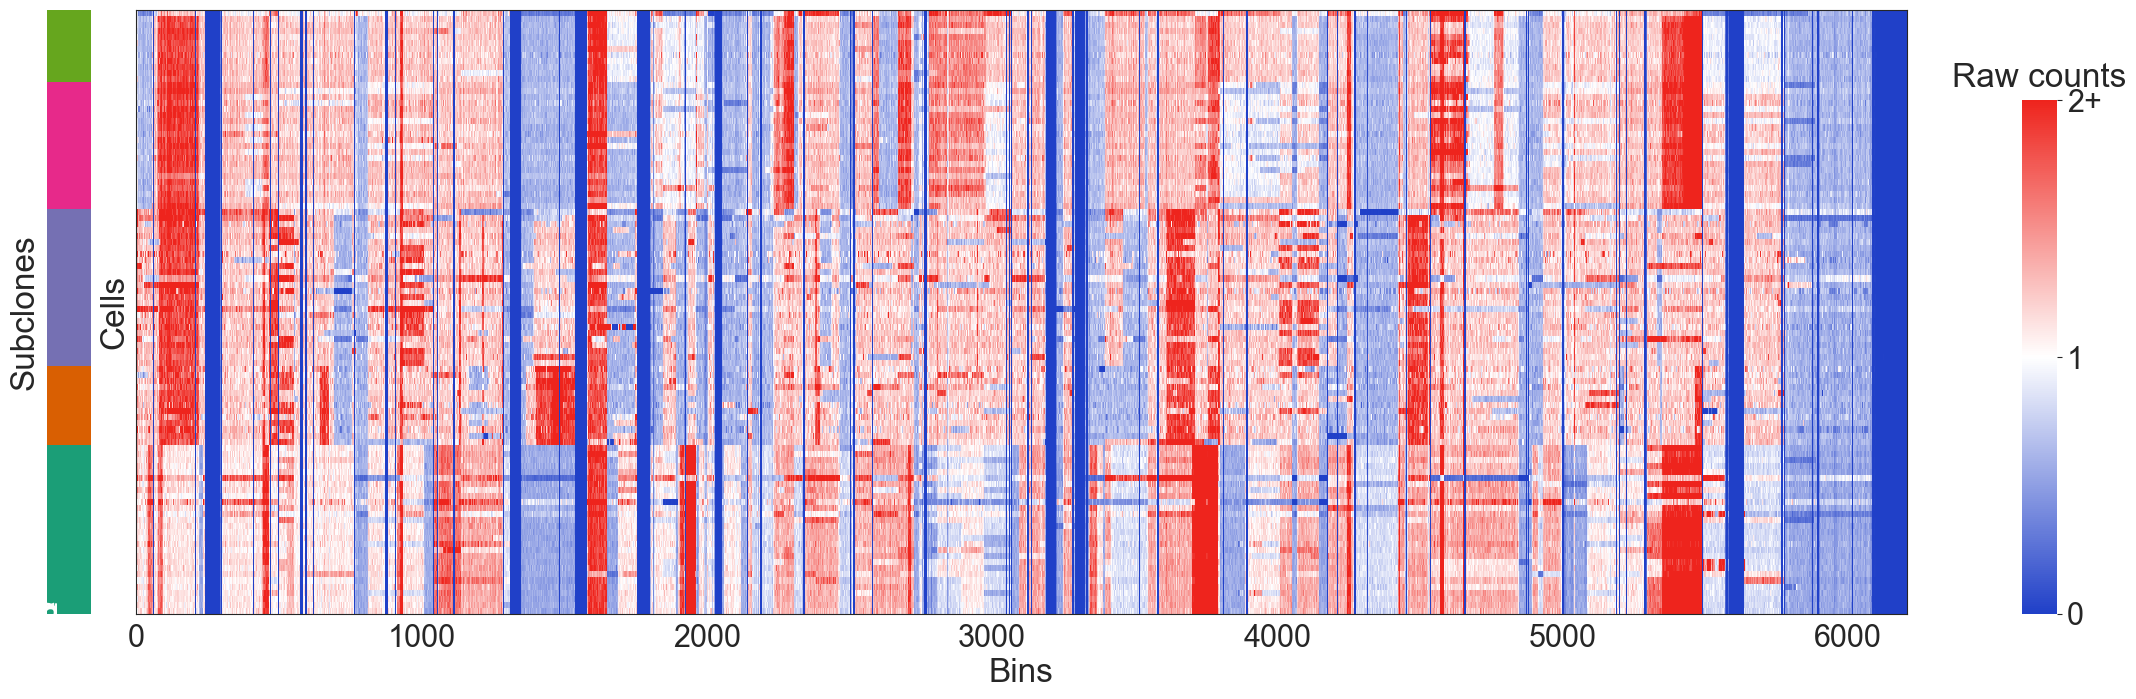

In [13]:

scicone.plotting.plot_matrix(
    normalized_counts, mode='data', cbar_title='Raw counts', vmax=2,
    labels=inferred_tree.cell_node_labels)


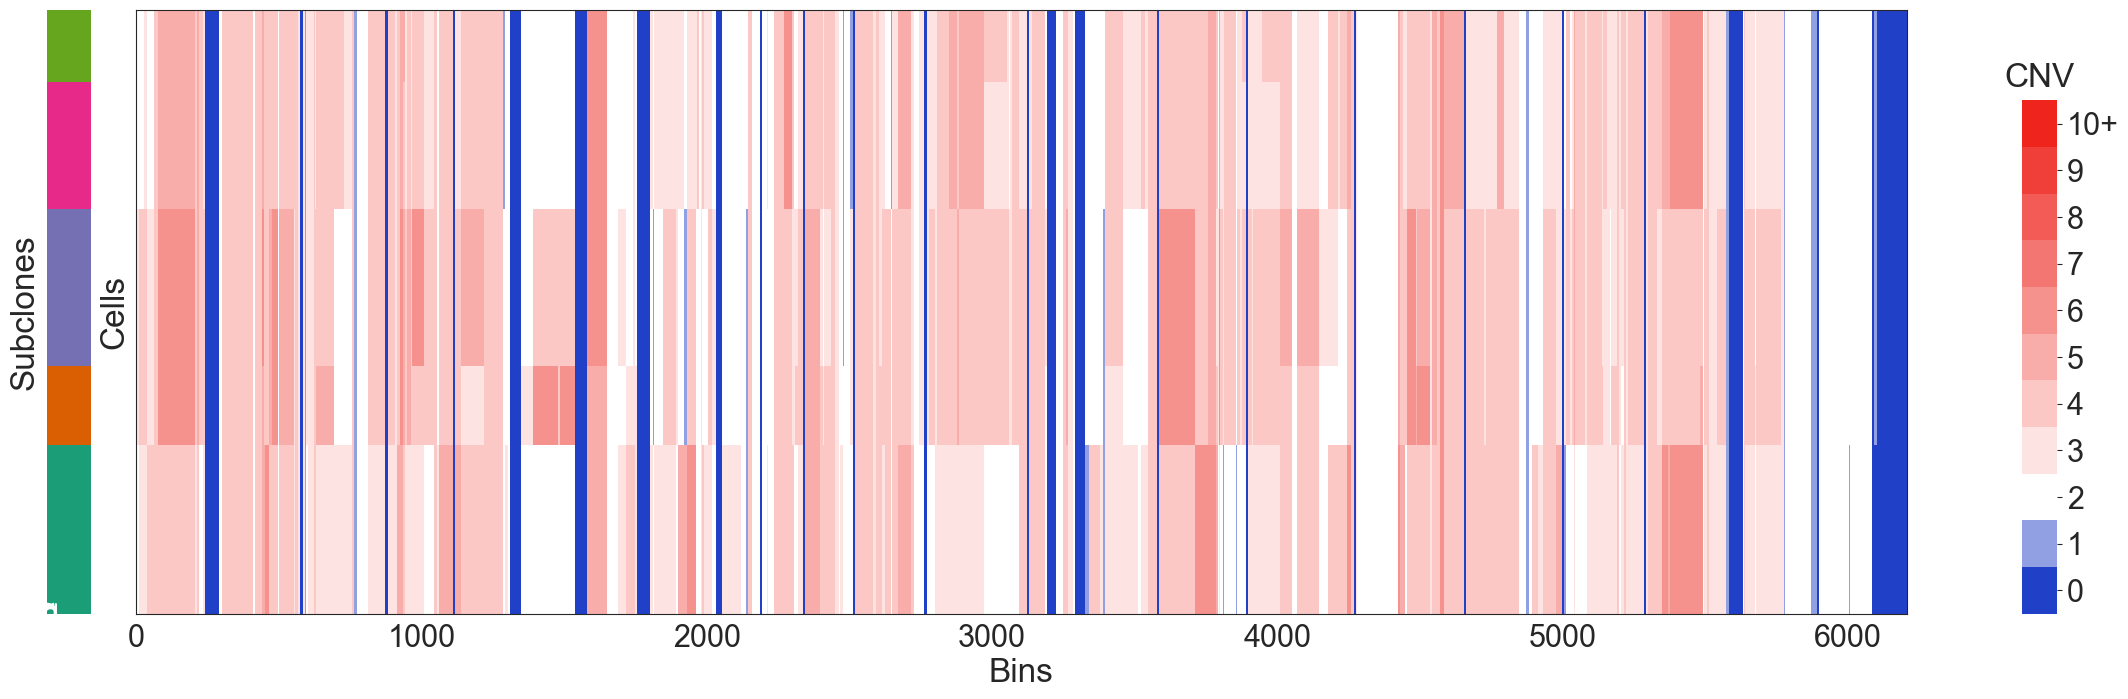

In [14]:

scicone.plotting.plot_matrix(
    inferred_tree.outputs['inferred_cnvs'], mode='cnv', cbar_title='CNV', vmax=10,
    labels=inferred_tree.cell_node_labels)
